In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as corr
import pickle
from tqdm import tqdm
import sys
from munkres import Munkres
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import gennorm
from typing import Union

from scipy.fft import dct

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cpu


In [2]:
# parameters
N = 16  # number of sparse sources
K = 3  # number of active components
M = 8  # number of measurements
seed = 20240625
num_data = 1024
lr = 3e-3
num_step = 20000
weight = 1e-2

In [14]:
def bound(N, K):
    return K * np.log10(N / K)

print('minimum M to solve problem', bound(N, K))

minimum M to solve problem 8.723984735235147


In [4]:
# helper
def sample_codes(S, S_):
    np.random.seed(seed)
    ind = np.random.choice(num_data, 9, replace=False)
    for j, i in enumerate(ind):
        plt.subplot(3, 3, j + 1)
        plt.plot(S[i], '.-')
        plt.plot(S_[i], '.-')
        plt.legend(['true', 'pred'])
    plt.tight_layout()
    plt.show()


def show_correlations(S, S_):
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.scatter(S[:, i], S_[:, i], s=3)
        plt.grid()
        plt.title('c=%.4f' % corr(S[:, i], S_[:, i])[0])
        plt.xlabel('true')
        plt.ylabel('learned')
    plt.tight_layout()
    plt.show()


def find_permutation(S, S_):
    matches, indexes = match_latents(S, S_)
    S__ = np.zeros_like(S_)
    for i in range(N):
        S__[:, i] = S_[:, indexes[i][1]].copy()
    return S__


def sample_signal():
    s = np.random.normal(0, 1, N)
    s = np.abs(s)
    ind = np.random.choice(N, K, replace=False)
    mask = np.zeros(N)
    mask[ind] = 1
    s *= mask
    return s


def analyze(S, S_):
    # permute
    plt.imshow(match_latents(S, S_)[0])
    plt.colorbar()
    plt.xlabel('true')
    plt.ylabel('learned')
    plt.title('As Learned')
    plt.show()
    S_ = find_permutation(S, S_)
    plt.imshow(match_latents(S, S_)[0])
    plt.colorbar()
    plt.xlabel('true')
    plt.ylabel('learned')
    plt.title('Optimal Permutation')
    plt.show()
    # analyze
    sample_codes(S, S_)
    show_correlations(S, S_)


def criterion(S_, X, X_, weight=weight):
    loss = torch.sum((X - X_) ** 2) + weight * torch.sum(torch.abs(S_))
    return loss


# Evaluation metric
munk = Munkres()
def match_latents(z, z_):
    matches = np.zeros((z.shape[1], z_.shape[1]))
    for i in range(z.shape[1]):
        for j in range(z_.shape[1]):
            matches[i, j] = abs(corr(z[:, i], z_[:, j])[0])
    matches[np.isnan(matches)] = 0
    indexes = munk.compute(-matches)
    return matches, indexes


def eval_nd(z, z_):
    matches, indexes = match_latents(z, z_)
    corrs = []
    for i in indexes:
        corrs.append(matches[i[0], i[1]])
    return corrs


def mcc(z, z_):
    return np.mean(eval_nd(z, z_))

In [5]:
class SparseCoding(nn.Module):
    def __init__(self, S, D, learn_D, seed=seed):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed)
        self.log_S_ = nn.Parameter(data=-10 * torch.ones(S.shape), requires_grad=True)
        if learn_D:
            self.D_ = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D_ = nn.Parameter(data=D, requires_grad=False)

    def forward(self, X=None):
        if self.learn_D:
            self.D_.data /= torch.linalg.norm(self.D_, dim=0, keepdim=True)
        S_ = torch.exp(self.log_S_)
        X_ = S_ @ self.D_
        return S_, X_


class Exp(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return torch.exp(X)


class SparseAutoEncoder(nn.Module):
    def __init__(self, D, learn_D, seed=seed, relu=True):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        if relu:
            self.encoder = nn.Sequential(nn.Linear(M, N), nn.ReLU())
        else:
            self.encoder = nn.Sequential(nn.Linear(M, N), Exp())
        if learn_D:
            self.D_ = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D_ = nn.Parameter(data=D, requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.D_.data /= torch.linalg.norm(self.D_, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = S_ @ self.D_
        return S_, X_


def train(model):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_step):
        S_, X_ = model.forward(X)
        loss = criterion(S_, X, X_, weight=weight)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if i > 0 and not i % 1000:
            # Print D_
            if not torch.all(S_.var(0) > 0):
                print('dead latents')
            print('step', i, 'loss', loss.item(),
                  'MCC', mcc(S, S_.detach().cpu().numpy()))
    S_ = S_.detach().cpu().numpy()
    print('final MCC', mcc(S, S_))
    return S_

In [6]:
import torch
import torch.nn.functional as F

# Create a sample matrix
matrix = torch.tensor([[1.0, 2.0, 3.0],
                       [4.0, 5.0, 6.0],
                       [7.0, 8.0, 9.0]])

# Normalize the columns of the matrix to have unit norm
normalized_matrix = F.normalize(matrix, p=1, dim=1)

print(normalized_matrix)

# Print the 1-norm of each column
print(torch.norm(normalized_matrix, p=1, dim=1))

tensor([[0.1667, 0.3333, 0.5000],
        [0.2667, 0.3333, 0.4000],
        [0.2917, 0.3333, 0.3750]])
tensor([1., 1., 1.])


In [7]:
# generate sample and move to torch
S = []
np.random.seed(seed)
for i in range(num_data):
    S.append(sample_signal())
S = np.array(S)
torch.manual_seed(seed)
D = torch.randn(N, M, dtype=torch.float32).to(device)
D /= torch.linalg.norm(D, dim=1, keepdim=True)
X = torch.tensor(S, dtype=torch.float32).to(device) @ D
print(S.shape, X.shape, D.shape)

(1024, 16) torch.Size([1024, 8]) torch.Size([16, 8])


## Sparse code, known dictionary

In [27]:
print(seed)

20240625


In [11]:
sc0 = SparseCoding(S, D, learn_D=False, seed=seed).to(device)
S_ = train(sc0)
# analyze(S, S_)

step 1000 loss 2900.755859375 MCC 0.3400785499128721
step 2000 loss 61.131675720214844 MCC 0.8507947371430317
step 3000 loss 36.01312255859375 MCC 0.9124316049494366
step 4000 loss 30.06017303466797 MCC 0.9391271118779269
step 5000 loss 27.88093376159668 MCC 0.9579500754524453
step 6000 loss 26.688621520996094 MCC 0.9717509279865721
step 7000 loss 25.95534896850586 MCC 0.980714718295348
step 8000 loss 25.487638473510742 MCC 0.9859537545689596
step 9000 loss 25.17985725402832 MCC 0.9888656632546955
step 10000 loss 24.97623634338379 MCC 0.9906697090529145
step 11000 loss 24.85106658935547 MCC 0.991484806266179
step 12000 loss 24.77254295349121 MCC 0.9918494425092037
step 13000 loss 24.72405242919922 MCC 0.9920430346145767
step 14000 loss 24.69402503967285 MCC 0.9922885619146616
step 15000 loss 24.675575256347656 MCC 0.9924467945815834
step 16000 loss 24.664522171020508 MCC 0.9924871805462621
step 17000 loss 24.657730102539062 MCC 0.9924986718406641
step 18000 loss 24.65350341796875 MCC 0

In [12]:
S_, X_ = sc0(X)
name = 'SparseCoding'
print(f"{name} activations shape: {S_.shape}")
print(f"{name} activations L0 norm: {torch.norm(S_, p=0)}")
print(f"{name} activations L1 norm: {torch.norm(S_, p=1)}")
print(f"{name} activations mean: {S_.mean()}")
print(f"{name} activations std: {S_.std()}")
print(f"{name} activations min: {S_.min()}")
print(f"{name} activations max: {S_.max()}\n\n")

SparseCoding activations shape: torch.Size([1024, 16])
SparseCoding activations L0 norm: 16384.0
SparseCoding activations L1 norm: 2451.865966796875
SparseCoding activations mean: 0.149651899933815
SparseCoding activations std: 0.40375491976737976
SparseCoding activations min: 4.205202408513742e-09
SparseCoding activations max: 3.7030467987060547




In [33]:
d = sc0.D_.data
print(d.shape)

# Print norms of each column
print(torch.norm(d, dim=1))

# Print norms of each row
print(torch.norm(d, dim=0))

torch.Size([16, 8])
tensor([0.6919, 0.5992, 0.7844, 0.6814, 0.8244, 0.8018, 0.6759, 0.5647, 0.7738,
        0.6269, 0.7796, 0.5668, 0.6071, 0.7786, 0.7320, 0.8499])
tensor([1.0066, 1.0102, 1.0099, 1.0118, 1.0115, 1.0117, 1.0122, 1.0103])


In [37]:
S, X = sc0(X)
S

tensor([[2.4657e-04, 1.5307e-05, 1.9896e-01,  ..., 1.2394e+00, 3.0002e-05,
         6.5479e-01],
        [1.3967e-05, 3.1662e-08, 1.0380e-05,  ..., 1.9460e-05, 2.5182e-01,
         1.0931e-06],
        [4.1629e-02, 9.7324e-05, 2.8427e-02,  ..., 2.0453e-08, 7.3696e-02,
         1.3835e-01],
        ...,
        [1.0676e-06, 1.0153e-01, 1.5224e+00,  ..., 2.4787e-04, 6.1403e-05,
         3.6002e-01],
        [2.0058e-06, 2.6845e-01, 4.3638e-06,  ..., 4.6163e-06, 4.8782e-02,
         1.0588e-01],
        [2.9048e-01, 3.0853e-06, 7.8018e-01,  ..., 4.8731e-04, 1.2276e+00,
         1.9703e-05]], grad_fn=<ExpBackward0>)

## Sparse autoencoder, known dictionary

In [10]:
import sys
sys.path.append('..')

In [12]:
from models import MLP

mlp0 = MLP(D, projections_up=[M*64, N], learn_D=False, seed=seed)
S_ = train(mlp0)

MLP init - N: 16, M: 8
Projections: [512, 16]
D norm after setting: 4.0
D requires_grad: False
dead latents
step 1000 loss 135.3232421875 MCC 0.6896817014546301


/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_60941/2685837302.py:76: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  matches[i, j] = abs(corr(z[:, i], z_[:, j])[0])


dead latents
step 2000 loss 131.87876892089844 MCC 0.683841864643974
dead latents
step 3000 loss 131.99012756347656 MCC 0.6830636086203007
dead latents
step 4000 loss 130.53402709960938 MCC 0.6826832624970953
dead latents
step 5000 loss 130.25146484375 MCC 0.6822661850310144
dead latents
step 6000 loss 130.03834533691406 MCC 0.6818840938434029
dead latents
step 7000 loss 130.6609649658203 MCC 0.6814877997542106
dead latents
step 8000 loss 130.22982788085938 MCC 0.6816924917103816
dead latents
step 9000 loss 131.24220275878906 MCC 0.68164710771765
dead latents
step 10000 loss 129.9433135986328 MCC 0.681389543163867
dead latents
step 11000 loss 129.83595275878906 MCC 0.6815420713001124


KeyboardInterrupt: 

In [11]:
from models import MLP

mlp0 = MLP(D, projections_up=[M*8, N], learn_D=True, seed=seed+2)
S_ = train(mlp0)
# analyze(S, S_)

MLP init - N: 16, M: 8
Projections: [64, 16]
D norm after setting: 11.243287086486816
D requires_grad: True
dead latents
step 1000 loss 48.43470764160156 MCC 0.5436405516665881


/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_76881/2685837302.py:76: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  matches[i, j] = abs(corr(z[:, i], z_[:, j])[0])


dead latents
step 2000 loss 38.844688415527344 MCC 0.5935954881011662
dead latents
step 3000 loss 34.880584716796875 MCC 0.6279405297367272
dead latents
step 4000 loss 32.83175277709961 MCC 0.6352681393311557
dead latents
step 5000 loss 32.348419189453125 MCC 0.6391323921999751
dead latents
step 6000 loss 32.12025833129883 MCC 0.6435232698378508
dead latents
step 7000 loss 31.93581199645996 MCC 0.6454246697601671
dead latents
step 8000 loss 31.925745010375977 MCC 0.6458227196802986
dead latents
step 9000 loss 31.91991424560547 MCC 0.6490038079351744
dead latents
step 10000 loss 31.905818939208984 MCC 0.649079524955175
dead latents
step 11000 loss 31.91366958618164 MCC 0.6500079356872956
dead latents
step 12000 loss 31.8635196685791 MCC 0.6496252883641143
dead latents
step 13000 loss 31.897602081298828 MCC 0.6498545973469447
dead latents
step 14000 loss 31.968765258789062 MCC 0.6498473305072349
dead latents
step 15000 loss 31.998619079589844 MCC 0.6503268118186513
dead latents
step 1600

step 1000 loss 72.0730972290039 MCC 0.5876638584254019
step 2000 loss 58.96758270263672 MCC 0.5725794121201133
step 3000 loss 55.88640594482422 MCC 0.5376533761644827
step 4000 loss 52.206119537353516 MCC 0.49291362893486934
dead latents


/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_7847/2685837302.py:76: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  matches[i, j] = abs(corr(z[:, i], z_[:, j])[0])


step 5000 loss 51.29975509643555 MCC 0.4948604660240896
dead latents
step 6000 loss 49.381431579589844 MCC 0.49880344522178466
dead latents
step 7000 loss 48.594825744628906 MCC 0.4947164775957833
dead latents
step 8000 loss 47.23643112182617 MCC 0.6021743795721206
dead latents
step 9000 loss 47.255210876464844 MCC 0.5642535224976815
dead latents
step 10000 loss 48.49842071533203 MCC 0.49969656797187567
dead latents
step 11000 loss 47.94740676879883 MCC 0.5423396920191508
dead latents
step 12000 loss 46.85544204711914 MCC 0.6028023859593401
dead latents
step 13000 loss 47.86859893798828 MCC 0.5445407207533626
dead latents
step 14000 loss 47.793758392333984 MCC 0.5827270592693601
dead latents
step 15000 loss 46.65849304199219 MCC 0.5743992554410782
dead latents
step 16000 loss 47.60136795043945 MCC 0.5512650482634062
dead latents
step 17000 loss 48.325714111328125 MCC 0.5362689607785661
dead latents
step 18000 loss 48.4789924621582 MCC 0.5305774754850229
dead latents
step 19000 loss 48.

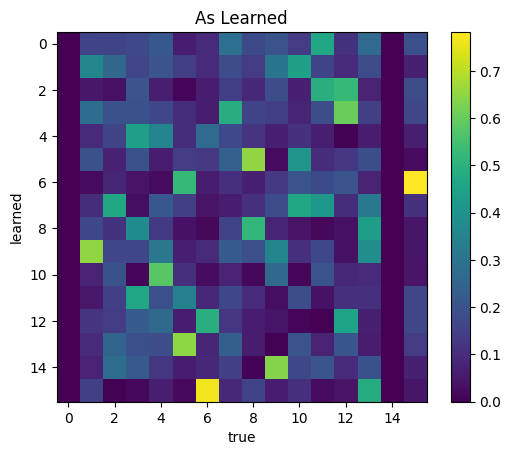

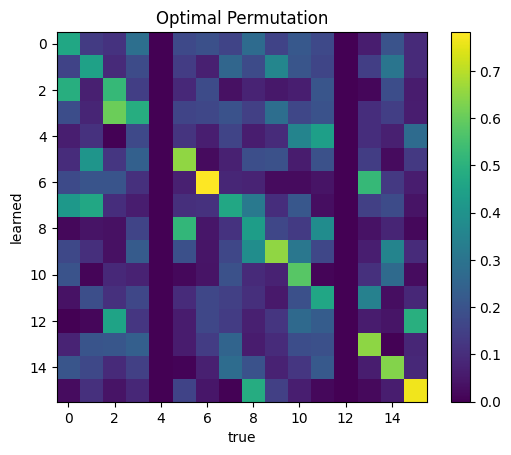

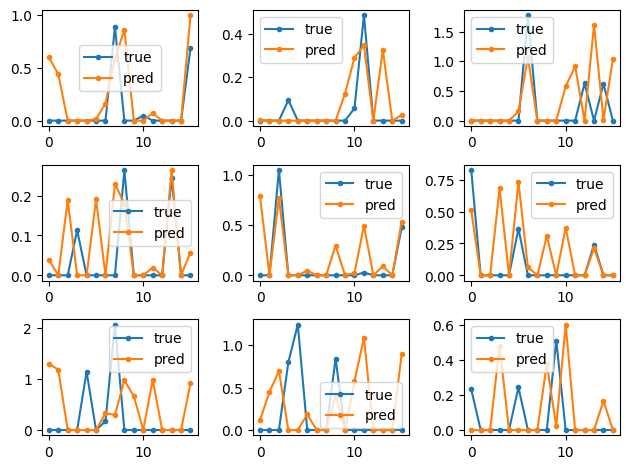

/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_7847/2685837302.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  plt.title('c=%.4f' % corr(S[:, i], S_[:, i])[0])


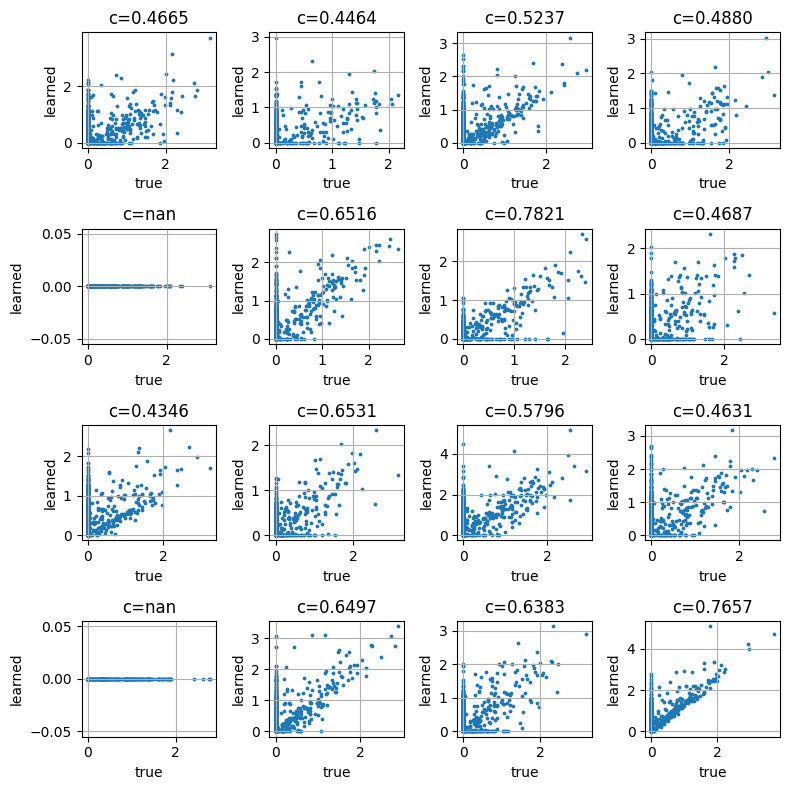

In [8]:
sae0 = SparseAutoEncoder(D, learn_D=True, seed=seed, relu=True).to(device)
S_ = train(sae0)
analyze(S, S_)

## Sparse coding, learning dictionary

step 1000 loss 2802.861328125 MCC 0.44692627353612313
step 2000 loss 190.0848388671875 MCC 0.7884879163620739
step 3000 loss 56.455055236816406 MCC 0.6840620576752856
step 4000 loss 40.4018669128418 MCC 0.7022185752485519
step 5000 loss 36.01589584350586 MCC 0.7603060655991399
step 6000 loss 33.72260665893555 MCC 0.8332903717294531
step 7000 loss 32.406097412109375 MCC 0.8782570703123871
step 8000 loss 31.444454193115234 MCC 0.9044704600663258
step 9000 loss 30.432964324951172 MCC 0.9106566462727823
step 10000 loss 29.928281784057617 MCC 0.9127237258016507
step 11000 loss 29.95750617980957 MCC 0.9064039285620016
step 12000 loss 30.395172119140625 MCC 0.9023476455992463
step 13000 loss 30.903287887573242 MCC 0.8827967783977304
step 14000 loss 31.8712100982666 MCC 0.7596269763283523
step 15000 loss 32.76664733886719 MCC 0.7432163460339449
step 16000 loss 32.20016860961914 MCC 0.7875955303226061
step 17000 loss 32.16244888305664 MCC 0.812685163272941
step 18000 loss 32.426448822021484 MCC

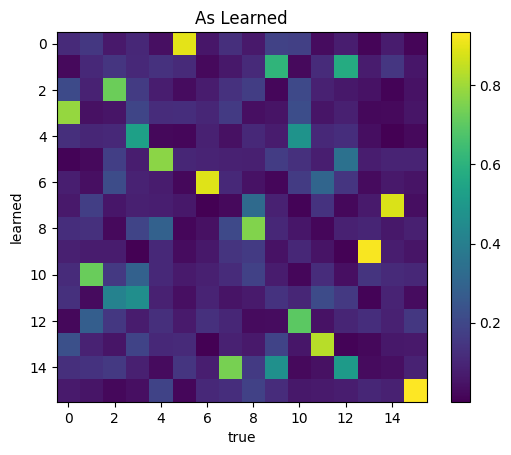

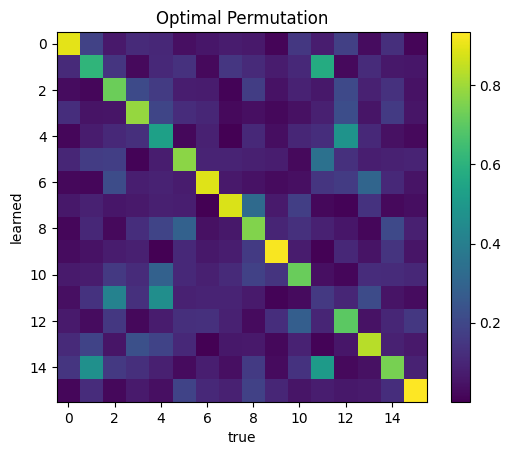

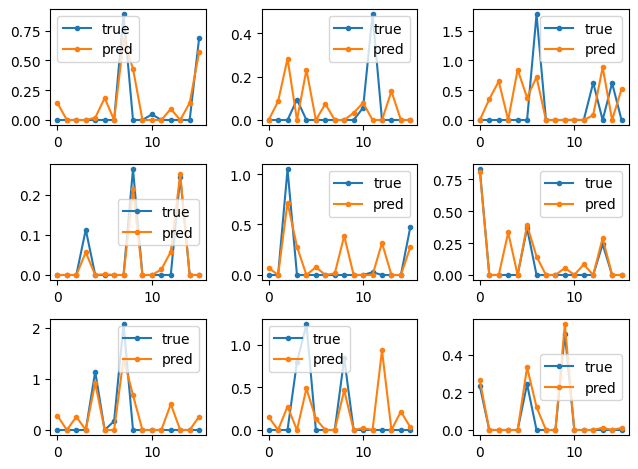

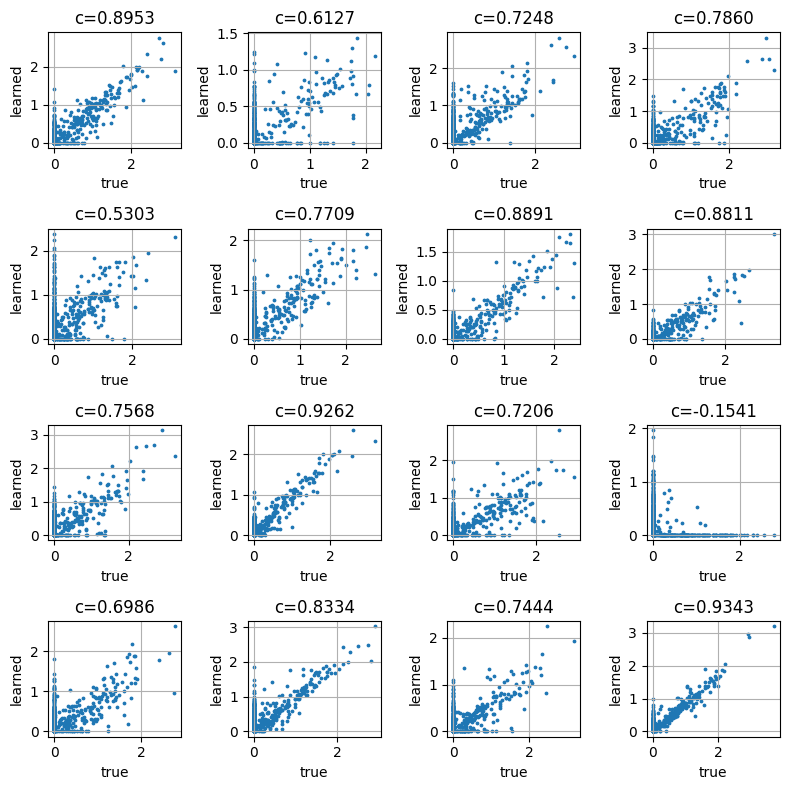

In [13]:
sc1 = SparseCoding(S, D, learn_D=True, seed=seed).to(device)
S_ = train(sc1)
analyze(S, S_)

## Sparse autoencoder, learning dictionary

step 1000 loss 200.42056274414062 MCC 0.6858140732629139
step 2000 loss 167.4375 MCC 0.4816326853872106
step 3000 loss 144.28041076660156 MCC 0.5015268901649161
step 4000 loss 128.1123504638672 MCC 0.7268936561425091
step 5000 loss 117.89173889160156 MCC 0.7369586328671494
step 6000 loss 115.10596466064453 MCC 0.7181525309140797
step 7000 loss 112.9382553100586 MCC 0.691669537175608
step 8000 loss 110.4206314086914 MCC 0.6166290908382845
step 9000 loss 109.93016052246094 MCC 0.4805933443788991
step 10000 loss 109.6013412475586 MCC 0.5908615060556821
step 11000 loss 109.79910278320312 MCC 0.4358979459926098
step 12000 loss 109.2861328125 MCC 0.403952798368286
step 13000 loss 107.87928771972656 MCC 0.4653050277207602
step 14000 loss 110.75048065185547 MCC 0.3862787428215929
step 15000 loss 111.33917999267578 MCC 0.4784845870254233
step 16000 loss 109.50566864013672 MCC 0.43208267463424554
step 17000 loss 109.45870971679688 MCC 0.43096285110452026
step 18000 loss 111.23261260986328 MCC 0.

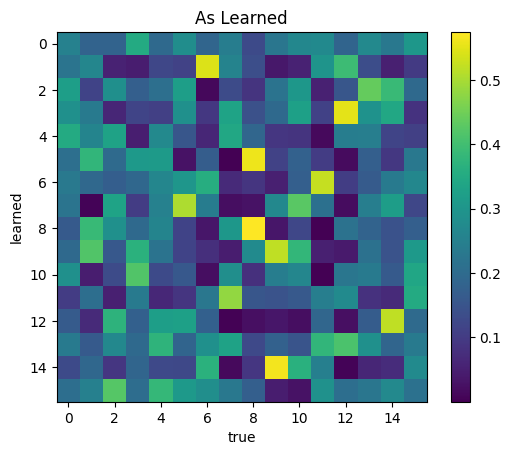

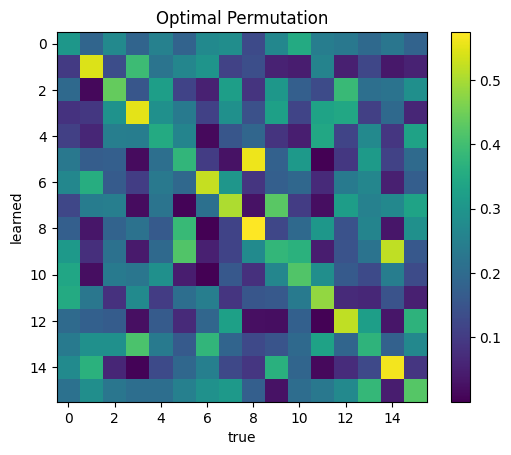

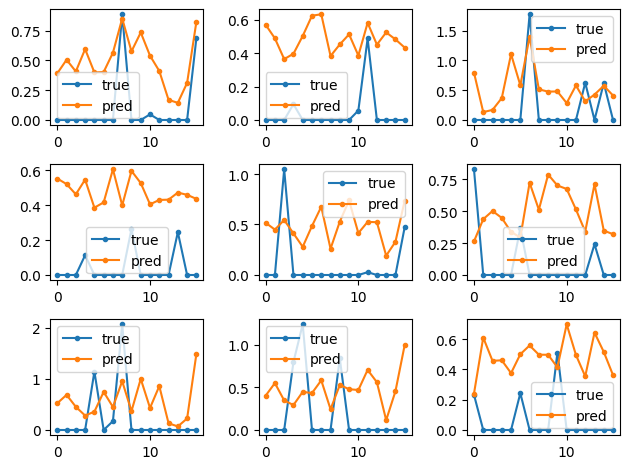

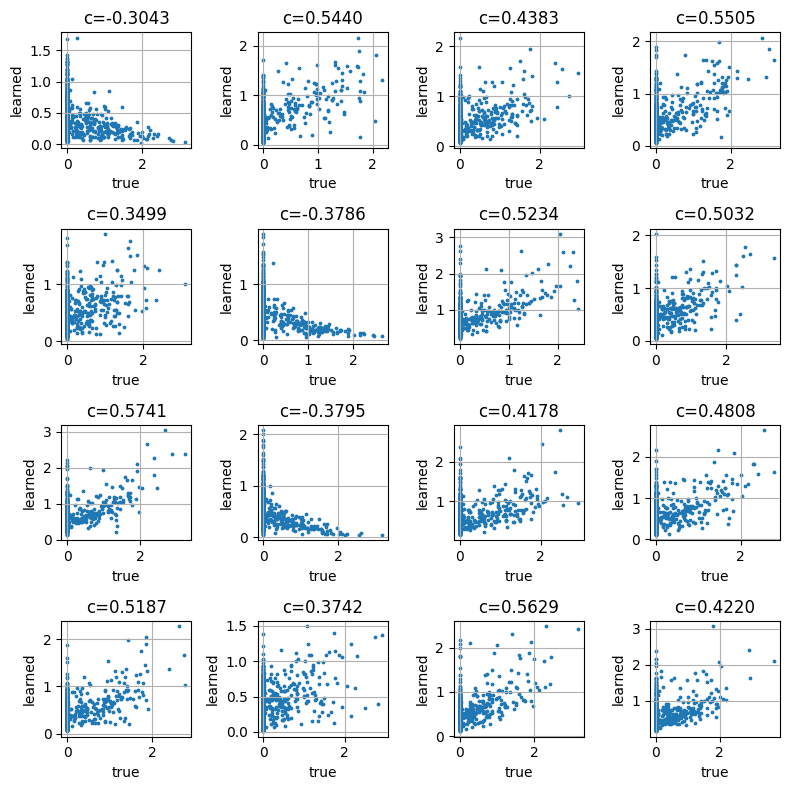

In [12]:
sae1 = SparseAutoEncoder(D, learn_D=True, seed=seed, relu=False,).to(device)
S_ = train(sae1)
analyze(S, S_)

## Scikit-Learn

In [23]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning
X, dictionary, code = make_sparse_coded_signal(
    n_samples=30, n_components=15, n_features=20, n_nonzero_coefs=10,
    random_state=42,
)

In [17]:
X.shape # B, M

(30, 20)

In [20]:
dictionary.shape # N, M

(15, 20)

In [22]:
code.shape # B, N

(30, 15)

## 